In [ ]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow

Создать три картинки 800х600px с белым фоном и разместить на них непересекающиеся: 100 одинаковых квадратов и 100 одинаковых прямоугольных равнобедренных треугольников (катет равен стороне квадрата) другого цвета следующим образом:

In [ ]:
width = 800
height = 600

square_part_len = 5
triangle_part_len = 5

existing_squares = []
existing_triangles = []

In [ ]:
def is_collision(new_rect, existing_shapes):
    new_left, new_top, new_right, new_bottom = new_rect
    for shape in existing_shapes:
        left, top, right, bottom = shape
        if not (new_right < left or new_left > right or new_bottom < top or new_top > bottom):
            return True
    return False

In [ ]:
def generate_square(border_left, border_right, margin=0, safety_zone=0):
  while True:
    x = random.randint(border_left + margin, border_right - safety_zone)
    y = random.randint(margin, height - margin - 1)

    square = (x, y, x + square_part_len, y + square_part_len)

    if not is_collision(square, existing_squares + existing_triangles):
        existing_squares.append(square)
        return square

In [ ]:
def generate_triangle(border_left, border_right, margin=0, safety_zone=0):
  while True:
    x = random.randint(border_left + safety_zone, border_right - margin - 1)
    y = random.randint(margin, height - margin - 1)

    triangle_points = [
        (x, y),
        (x - triangle_part_len, y + triangle_part_len),
        (x + triangle_part_len, y + triangle_part_len)
    ]

    left = min(p[0] for p in triangle_points)
    right = max(p[0] for p in triangle_points)
    top = min(p[1] for p in triangle_points)
    bottom = max(p[1] for p in triangle_points)
    new_triangle_rect = (left, top, right, bottom)

    if not is_collision(new_triangle_rect, existing_squares + existing_triangles):
        existing_triangles.append(new_triangle_rect)
        return triangle_points

1-й рисунок: квадраты и треугольники образуют две непересекающиеся области, которые  визуально легко разделить прямой линией:

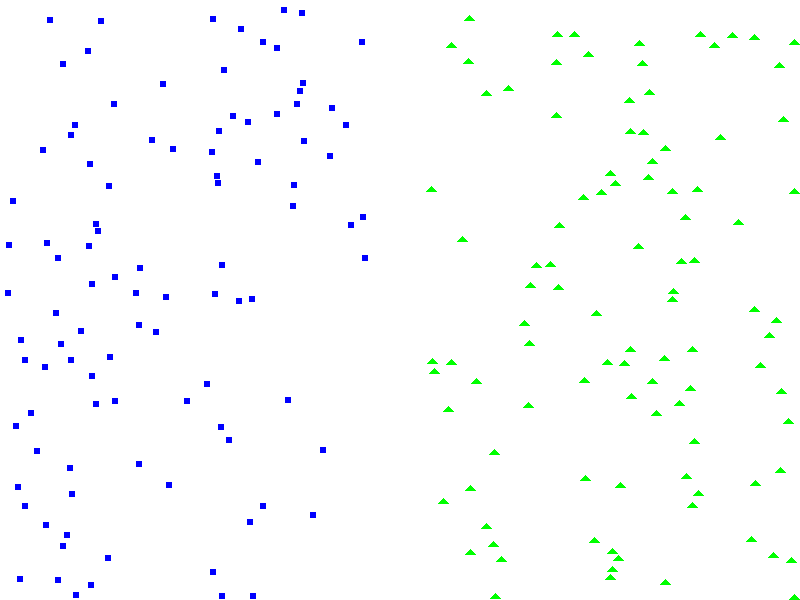

In [ ]:
canvas1 = np.full((height, width, 3), 255, np.uint8)
data1 = []
labels1 = []

for i in range(100):
  square = generate_square(0, width // 2, square_part_len, 30)
  x, y, x1, y1 = square
  data1.append((x, y))
  labels1.append(0)
  cv2.rectangle(canvas1, (x, y), (x1, y1), (255, 0, 0), -1)

  triangle = generate_triangle(width // 2, width, margin=5, safety_zone=30)
  x, y = triangle[0]
  data1.append((x, y))
  labels1.append(1)

  cv2.drawContours(canvas1, [np.array(triangle)], -1, (0, 255, 0), -1)

cv2_imshow(canvas1)

2-й рисунок: квадраты и треугольники образуют две непересекающиеся области, которые  разделяются прямой линией, при этом достаточно большое фигур обоих типов близки к этой линии:

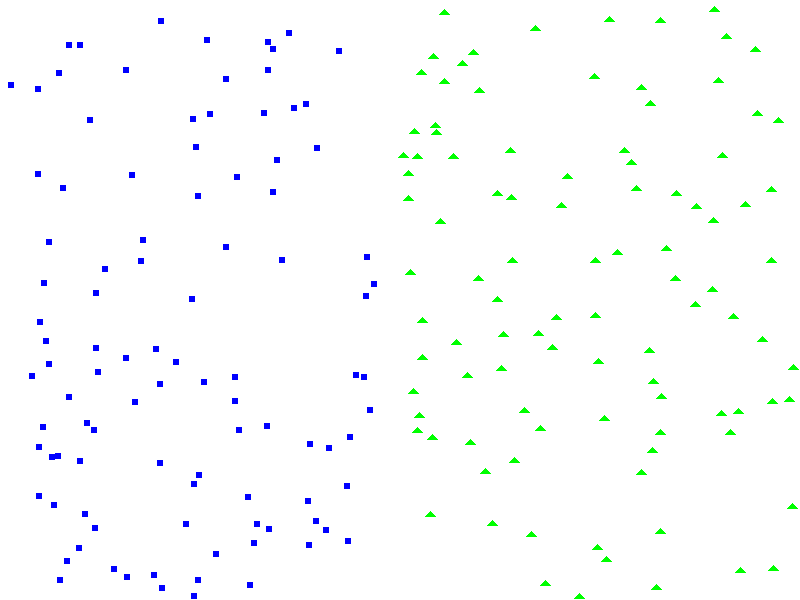

In [ ]:
canvas2 = np.full((height, width, 3), 255, np.uint8)
data2 = []
labels2 = []

existing_squares = []
existing_triangles = []
for i in range(100):
  square = generate_square(0, width // 2, square_part_len, 3)
  x, y, x1, y1 = square
  data2.append((x, y))
  labels2.append(0)
  cv2.rectangle(canvas2, (x, y), (x1, y1), (255, 0, 0), -1)

  triangle = generate_triangle(width // 2, width, square_part_len, 3)
  x, y = triangle[0]
  data2.append((x, y))
  labels2.append(1)

  cv2.drawContours(canvas2, [np.array(triangle)], -1, (0, 255, 0), -1)

cv2_imshow(canvas2)

3-й рисунок: квадраты и треугольники образуют две пересекающиеся области, при этом в небольшом пересечении этих областей находится 6-10 фигур одного типа и 3-5 фигур другого типа. Остальные фигуры легко визуального разделяются прямой на две непересекающиеся области.

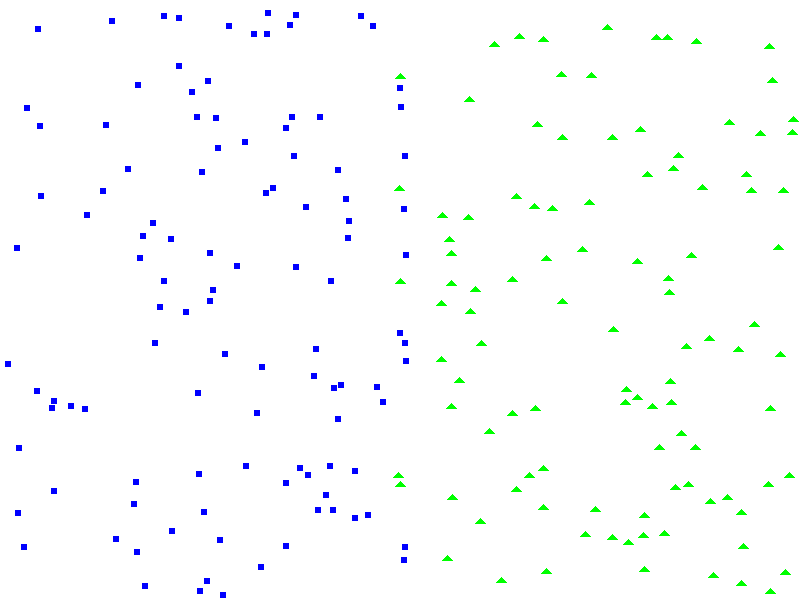

In [ ]:
canvas3 = np.full((height, width, 3), 255, np.uint8)
data3 = []
labels3 = []

existing_squares = []
existing_triangles = []
for i in range(100):
  square = generate_square(0, width // 2, square_part_len, 5)
  x, y, x1, y1 = square
  data3.append((x, y))
  labels3.append(0)
  cv2.rectangle(canvas3, (x, y), (x1, y1), (255, 0, 0), -1)

  triangle = generate_triangle(width // 2, width, margin=5, safety_zone=30)
  x, y = triangle[0]
  data3.append((x, y))
  labels3.append(1)

  cv2.drawContours(canvas3, [np.array(triangle)], -1, (0, 255, 0), -1)

for i in range(10):
  square = generate_square(width // 2 - 3, width // 2 + 3)
  x, y, x1, y1 = square
  data3.append((x, y))
  labels3.append(0)
  cv2.rectangle(canvas3, (x, y), (x1, y1), (255, 0, 0), -1)

for i in range(5):
  triangle = generate_triangle(width // 2 - 3, width // 2 + 3)
  x, y = triangle[0]
  data3.append((x, y))
  labels3.append(1)
  cv2.drawContours(canvas3, [np.array(triangle)], -1, (0, 255, 0), -1)

cv2_imshow(canvas3)

Для каждого из рисунков методом k-средних разбить выборку треугольников и квадратов на два класса.

In [ ]:
def kmeans(data, labels, canvas):
  qp = np.array(data, np.float32)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.5)
  labels = np.array(labels, dtype=np.int32)
  retval, p_class, centers = cv2.kmeans(qp, 2, labels, criteria, 5, flags=cv2.KMEANS_USE_INITIAL_LABELS)

  cl1 = qp[p_class.ravel()==0] # Экземпляры класса 0
  cl2 = qp[p_class.ravel()==1] # Экземпляры класса 1

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  axs[0].scatter(cl1[:,0], cl1[:,1], s=20, marker='s', c='r')
  axs[0].scatter(cl2[:,0], cl2[:,1], s=20, marker='^', c='g')
  axs[0].scatter(centers[:,0], centers[:,1], s=50, c='b', marker='s')
  axs[0].invert_yaxis()
  axs[1].imshow(canvas, cmap='gray')
  plt.show()

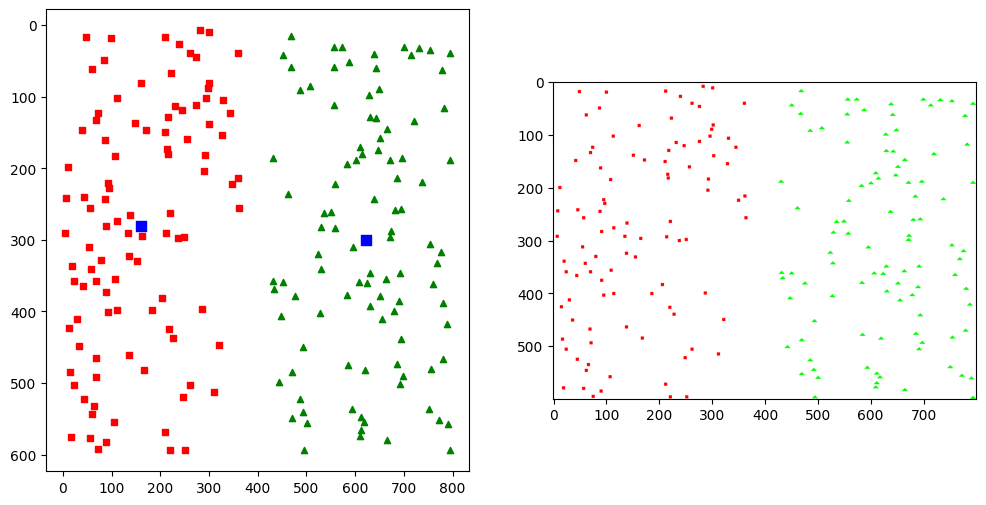

In [ ]:
kmeans(data1, labels1, canvas1)

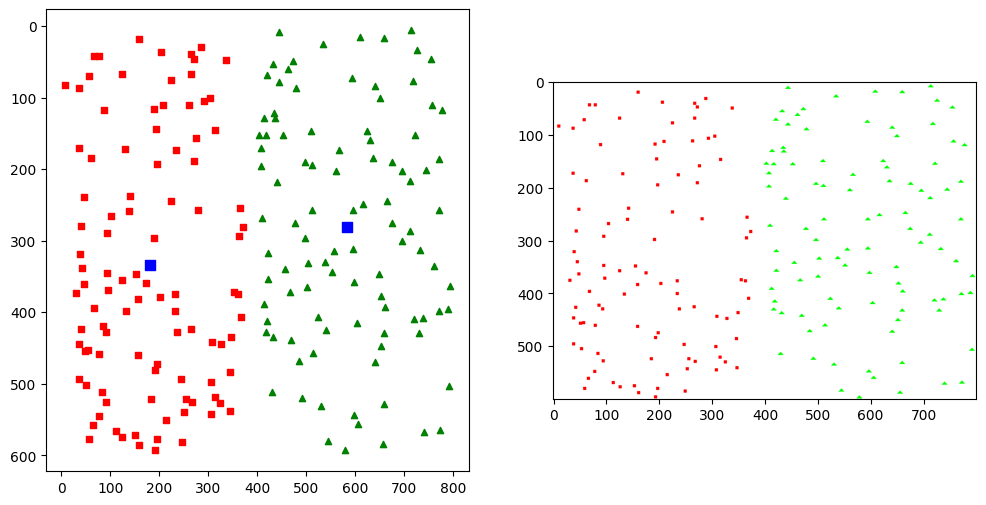

In [ ]:
kmeans(data2, labels2, canvas2)

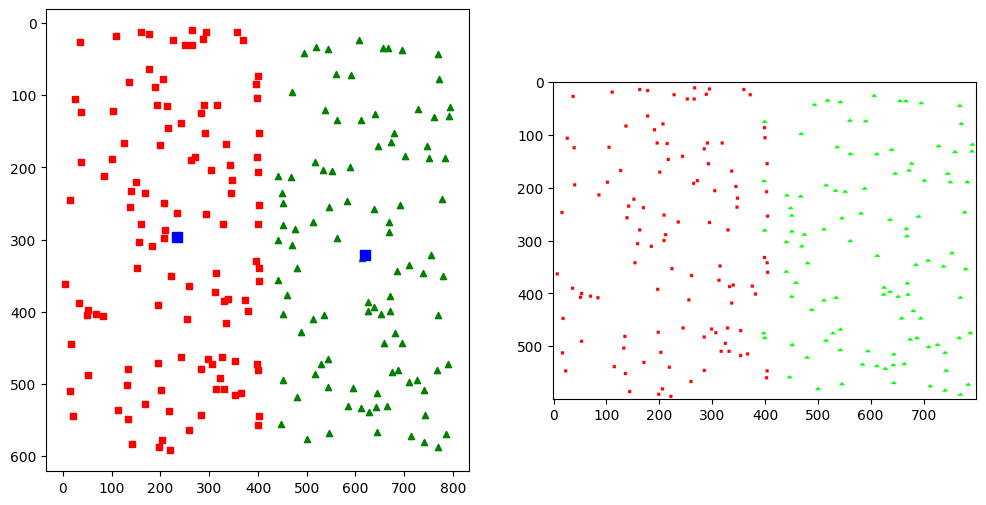

In [ ]:
kmeans(data3, labels3, canvas3)

На каждой картинке разместить 9 кругов (диаметр равен стороне квадрата): по 3 круга в первой области, во второй области, в пересечении областей или близко к линии разделения областей. Провести классификацию кругов методом k ближайших соседей.

In [ ]:
test_data = []
for i in range(3):
  x, y = np.random.randint(0, width // 2 - 10, size=2)
  test_data.append((x, y))

for i in range(3):
  x, y = np.random.randint(width // 2 - 5, width // 2 + 5, size=2)
  test_data.append((x, y))

for i in range(3):
  x, y = np.random.randint(width // 2, width + 10, size=2)
  test_data.append((x, y))

In [ ]:
def knearest(train_data, labels, canvas):
  knn = cv2.ml.KNearest_create()
  train_data = np.array(train_data, np.float32)
  labels = np.array(labels, dtype=np.int32)
  knn.train(train_data, cv2.ml.ROW_SAMPLE, labels)

  _, res, _, _ = knn.findNearest(np.array(test_data, np.float32), 1)
  for i in range(len(test_data)):
    if res[i] == 0:
      color = (255, 0, 0)
    elif res[i] == 1:
      color = (0, 255, 0)
    cv2.circle(canvas, test_data[i], square_part_len // 2, color, -1)

  cv2_imshow(canvas)

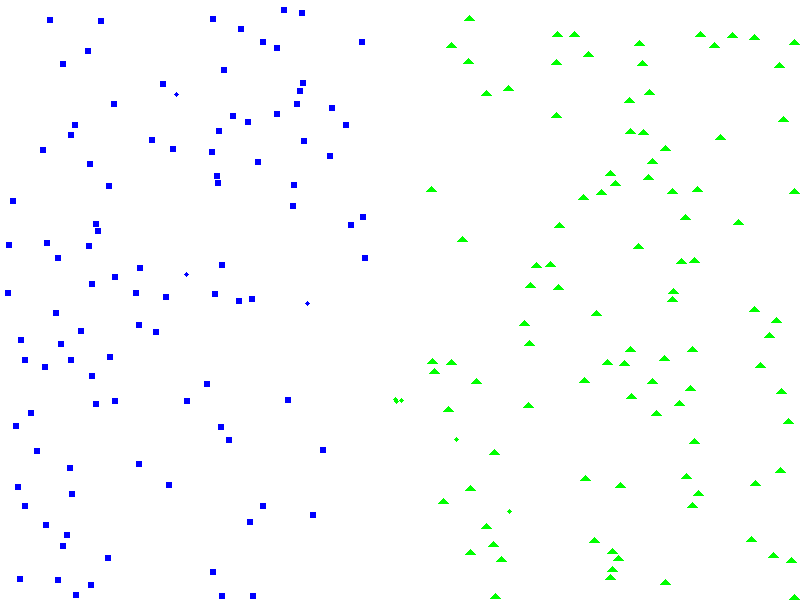

In [ ]:
res = knearest(data1, labels1, canvas1)

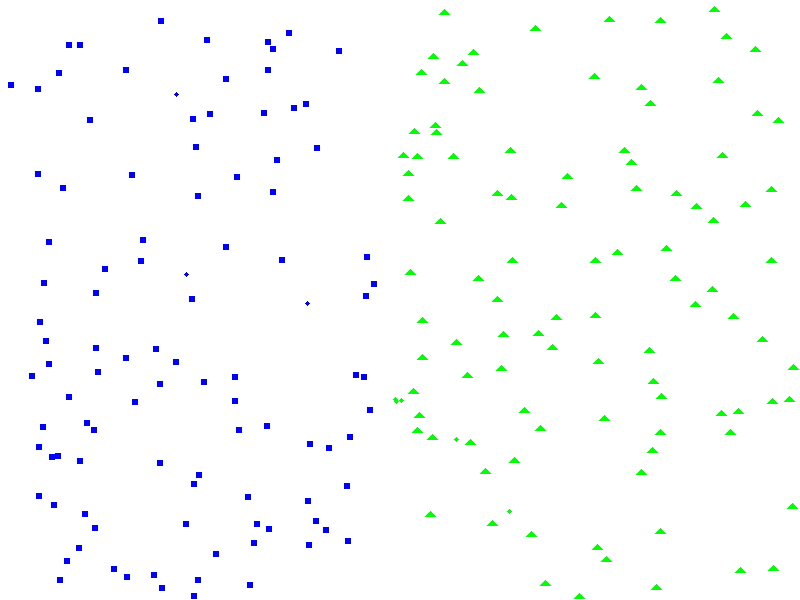

In [ ]:
res = knearest(data2, labels2, canvas2)

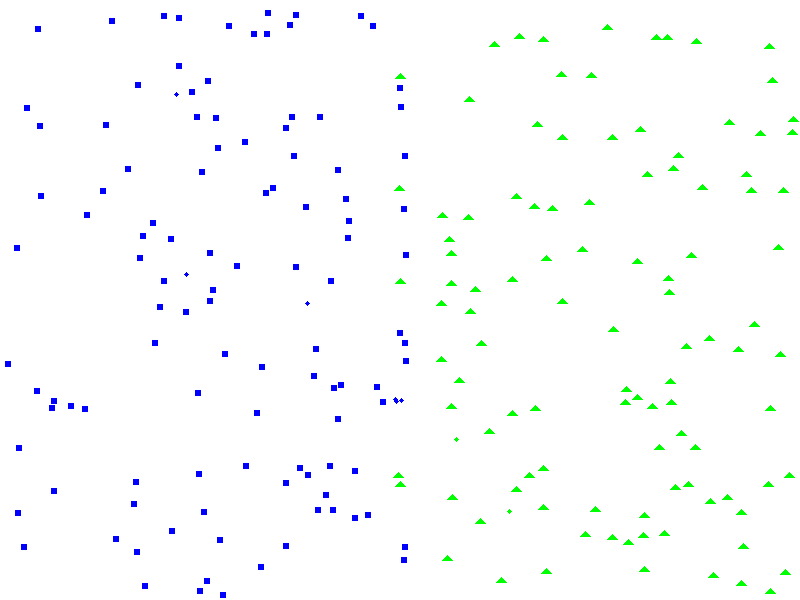

In [ ]:
res = knearest(data3, labels3, canvas3)
